# Validación del Modelo de Regresión Logística

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)


In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

In [3]:
from pyspark.ml.feature import VectorAssembler

bd5 = bd5.withColumn('Horario1',(bd5.Horario==1) 
).withColumn('Horario2',(bd5.Horario==2) 
).withColumn('Horario3',(bd5.Horario==3))

# Términos cuadráticos añadidos manualmente
bd5 = bd5.withColumn('DepDelay2',(bd5.DepDelay**2)
).withColumn('DepD_Distance',(bd5.DepDelay * bd5.Distance)) 

Configuración de la Base de Datos

In [4]:
from pyspark.sql.functions import col

a1  = VectorAssembler(
    inputCols=['DepDelay','Distance','DayOfWeek',
               'CRSDepTime','Horario1','Horario2',
               'Horario3','DepDelay2','DepD_Distance'],
    outputCol='features')

bd6 = a1.transform(bd5).select(col("Retraso").cast('double').alias("label"),'features')

## Ajuste del modelo

In [5]:
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",
     threshold=0.5)
                        
model = lgr.fit(bd6)

In [6]:
print(model.intercept,model.coefficients)

-1.6228762950366733 [0.0174818630425,-0.000153907645432,0.00622037724017,0.000243814478493,-0.18527035429,0.0280656797875,0.0553254124157,1.4042617353e-06,9.64852764749e-06]


In [7]:
pred = model.transform(bd6)



/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


In [8]:
pred.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[-5.0,1235.0,4.0,...|[1.70093568096363...|[0.84565690072126...|       0.0|
|  0.0|[5.0,1235.0,5.0,8...|[1.40073735685147...|[0.80230086988420...|       0.0|
|  0.0|[-3.0,1235.0,6.0,...|[1.62972180529665...|[0.83613152532732...|       0.0|
|  0.0|[-7.0,1235.0,7.0,...|[1.74103643633586...|[0.85081866429966...|       0.0|
|  0.0|[-6.0,1235.0,1.0,...|[1.74897916049225...|[0.85182399800571...|       0.0|
|  0.0|[-1.0,1235.0,2.0,...|[1.59581895897683...|[0.83143321551653...|       0.0|
|  0.0|(9,[1,2,3,5],[123...|[1.56020219131119...|[0.82638236420325...|       0.0|
|  0.0|(9,[1,2,3,5],[123...|[1.55398181407102...|[0.82548808566343...|       0.0|
|  0.0|[-1.0,1235.0,5.0,...|[1.57715782725631...|[0.82880162030731...|       0.0|
|  0.0|[-1.0,123

Los valores de *probability* son transformados a *prediction* empleando un punto de corte. 

Por defecto: 0.5

## Confussion Matrix

In [9]:
pred.count()

30466

In [10]:
cm = pred.groupBy('label','prediction').count().sort('label','prediction')
cm.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|22056|
|  0.0|       1.0|    9|
|  1.0|       0.0| 5119|
|  1.0|       1.0| 3282|
+-----+----------+-----+



In [11]:
TN = cm.filter((cm.label == 0) & (cm.prediction == 0)).collect()[0][2]
FP = cm.filter((cm.label == 0) & (cm.prediction == 1)).collect()[0][2]
FN = cm.filter((cm.label == 1) & (cm.prediction == 0)).collect()[0][2]
TP = cm.filter((cm.label == 1) & (cm.prediction == 1)).collect()[0][2]

N=TN+FP+TP+FN

Prev = (TP + FN) / N  
Sens = TPR = Recall = TP / (TP + FN) 
Esp  = TN / (TN + FP) #= (1 - FPR)
Precision = PPV = TP / (TP + FP) 
Acc = (TP+TN) / N

print('Prev=',Prev)
print('Sens=',Sens)
print('Esp=',Esp)
print('Recall=',Recall)
print('Precision=',Precision)
print('Acc=',Acc)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MCE
print('Acc=',MCE(metricName="weightedRecall").evaluate(pred))

Prev= 0.2757500164117377
Sens= 0.3906677776455184
Esp= 0.9995921142080217
Recall= 0.3906677776455184
Precision= 0.9972652689152234
Acc= 0.8316812184074049
Acc= 0.8316812184074049


## Modificacion del Punto de Corte

In [12]:
lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",                         
     threshold=0.27)
#threshold=Prev

model = lgr.fit(bd6)
pred = model.transform(bd6)


cm = pred.groupBy('label','prediction').count().sort('label','prediction')
cm.show()

print('Acc=',MCE(metricName="weightedRecall").evaluate(pred))

/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|20464|
|  0.0|       1.0| 1601|
|  1.0|       0.0| 1803|
|  1.0|       1.0| 6598|
+-----+----------+-----+

Acc= 0.8882688899100637


## Curva ROC

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

secondelement=udf(lambda v:float(v[1]),FloatType())
pred2=pred.withColumn('probs',secondelement('probability'))

pred2.show(10)

+-----+--------------------+--------------------+--------------------+----------+----------+
|label|            features|       rawPrediction|         probability|prediction|     probs|
+-----+--------------------+--------------------+--------------------+----------+----------+
|  0.0|[-5.0,1235.0,4.0,...|[1.70093568096363...|[0.84565690072126...|       0.0| 0.1543431|
|  0.0|[5.0,1235.0,5.0,8...|[1.40073735685147...|[0.80230086988420...|       0.0|0.19769913|
|  0.0|[-3.0,1235.0,6.0,...|[1.62972180529665...|[0.83613152532732...|       0.0|0.16386847|
|  0.0|[-7.0,1235.0,7.0,...|[1.74103643633586...|[0.85081866429966...|       0.0|0.14918134|
|  0.0|[-6.0,1235.0,1.0,...|[1.74897916049225...|[0.85182399800571...|       0.0|  0.148176|
|  0.0|[-1.0,1235.0,2.0,...|[1.59581895897683...|[0.83143321551653...|       0.0|0.16856678|
|  0.0|(9,[1,2,3,5],[123...|[1.56020219131119...|[0.82638236420325...|       0.0|0.17361763|
|  0.0|(9,[1,2,3,5],[123...|[1.55398181407102...|[0.82548808566343...|

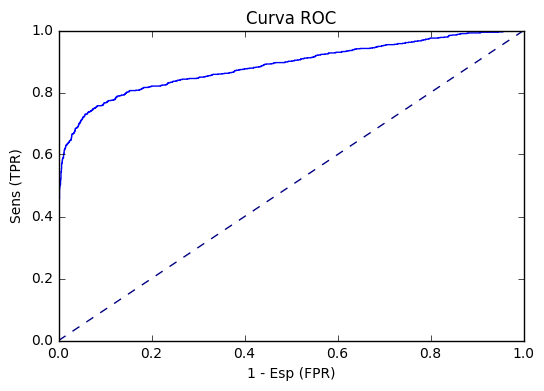

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import seaborn as sns

pd5 = pred2.sample(False,0.1).select('label','probs').toPandas()

fpr, tpr, _ = roc_curve( pd5['label'], pd5['probs'])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('1 - Esp (FPR)')
plt.ylabel('Sens (TPR)')
plt.title('Curva ROC')
plt.show()

## Área Bajo la Curva ROC

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred))
print('AUC=',BCE(metricName="areaUnderROC").evaluate(pred))

AUC= 0.9053308831809765
AUC= 0.9053308831809694


In [16]:
#LogisticRegression(maxIter=10, 
#     labelCol="label", 
#     featuresCol="features",
#     predictionCol="prediction", 
#     regParam=0.1, 
#     elasticNetParam=0.0, 
#     fitIntercept=True, 
#     threshold=0.5, 
#     probabilityCol="probability", 
#     rawPredictionCol="rawPrediction", 
#     standardization=True, 
#     weightCol=None)